In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries, TimeSeriesDict
from gwpy.time import tconvert
from numpy import *
from numpy.fft import rfft, irfft
import numpy.random as rnd
import scipy.signal as sig

In [2]:
#st=1186981218
#et=st+3*3600
#st=1164683417
#et=st+7200
st=1170581984
et=st+7200

In [5]:
print tconvert(st)

2017-02-08 09:39:26


In [4]:
data = TimeSeries.fetch('L1:DCH-CLEAN_STRAIN_C02', st, et, verbose=True)

Opening new connection to nds.ldas.cit... connected
    [nds.ldas.cit] set ALLOW_DATA_ON_TAPE='False'
Checking channels list against NDS2 database... done


In [6]:
data = data.resample(2048, window='hann')
srate = int(data.sample_rate.value)

In [7]:
# Get the PSD with segments of 16 seconds
psd = data.psd(16,8,method='median')

/home/lundgren/.conda/envs/gwpy-git/lib/python2.7/site-packages/gwpy/signal/fft/basic.py:51: UserWarning: no FFT method registered as 'median', using 'pycbc_median', please consider specifying this directly in the future
  name, regname))


To get the normalization correct, it helps to break the filter into two pieces. The filters are based on the estimated (long) power spectrum denoted $S_{E}(f)$.

The first is the whitener, which is the inverse of the ASD in the frequency domain. The normalization that we want is that the whitened noise has variance one in the time domain.

$$\widetilde{W}(f) = \frac{f_{s}}{2} ~ \frac{1}{\sqrt{S_{E}(f)}}$$

The second is a filter that weights by the power in the whitened template. It looks like

$$\widetilde{H}(f) = \mathcal{N} ~ \frac{f^{-7/6}}{\sqrt{S_{E}(f)}}$$

The normalization is chosen so that the variance will be one if this filter is white noise which already has a variance of one. In the frequency domain, the sum of $|\widetilde{H}(f)|^2$ must equal the number of frequency bins in the filter (not including the one at $f = 0$).

In [8]:
# Make a bandpass filter to remove uninteresting frequencies
filt = sig.firwin(4*srate, [20.,480.], pass_zero=False, window='hann', fs=srate)
filt.resize(16*srate)

In [22]:
# Make the weighting filter - bandpass, weight by f^-7/6, and whiten
# This will give a divide by zero because of the f=0 point, ignore it
fweight = psd.frequencies**(-7./6.)*abs(rfft(filt))/sqrt(psd)
fweight[0] = 0. # Remove anything at f=0
norm = 1. / sqrt(sum(abs(fweight)**2) / (len(fweight)-1.))
fweight = norm * fweight.value

In [23]:
fwhiten = sqrt(2./srate)/sqrt(psd.value)
fwhiten[0] = 0. # Remove anything at f=0
td_whitener = sig.hann(16*srate)*roll(irfft(fwhiten), 8*srate)

In [24]:
full_filt = sig.hann(16*srate)*roll(irfft(fwhiten*fweight), 8*srate)

In [25]:
wdata = TimeSeries(sig.fftconvolve(data, full_filt, mode='same'),
                       sample_rate=data.sample_rate, epoch=data.epoch)[8*2048:-8*2048]

In [28]:
sum(abs(fweight)**2) / (16*2048/2.)

<Index 1. ct2 Hz(4/3)>

(0.8, 1.2)

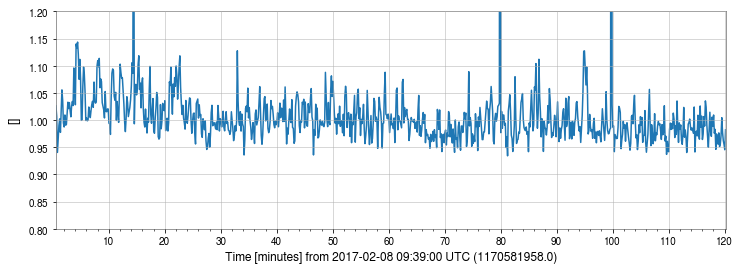

In [33]:
p1 = wdata.rms(8).plot()
p1.gca().set_ylim(0.8,1.2)

The things below are not really needed. At this point, we've got a time series whose variance is the predicted variance of the SNR. Taking an RMS gives the predicted standard deviation.

In [208]:
# Alternately, apply directly by FFT
# 1. Pad filter with zeros up to length of data
# 2. Multiply RFFT of data by abs(RFFT(filter))
# (Taking abs is the easy way to make sure a zero-phase filter has zero delay, even after padding)
# 3. Now take the IRFFT 

if False:
    wfilt_long = wfilt.copy()
    wfilt_long.resize(len(data))
    wdata = TimeSeries(irfft(rfft(data)*abs(rfft(wfilt_long))),
                       sample_rate=data.sample_rate, epoch=data.epoch)[8*2048:-8*2048]

In [209]:
# We can use the RMS to calculate the variance
# This is the same as integrating the spectrum, by Parseval's theorem
# But in practice, the spectrum may be better because we can use median or median-mean
# Note that I'm being lazy and not calculating the norm - just dividing by the median
# I'll do the norm next

my_rms = wdata.rms(8)
my_rms /= median(my_rms.value)

In [192]:
wdata.sample_rate

<Quantity 2048. Hz>

In [210]:
result = []
for idx in range(0, len(wdata)-8*2048, 4*2048):
    result.append(sqrt(median(wdata[idx:idx+8*2048].value**2)))
rmd = array(result)
rmd /= median(rmd)
rmd = TimeSeries(rmd, sample_rate=0.25, epoch=wdata.epoch)

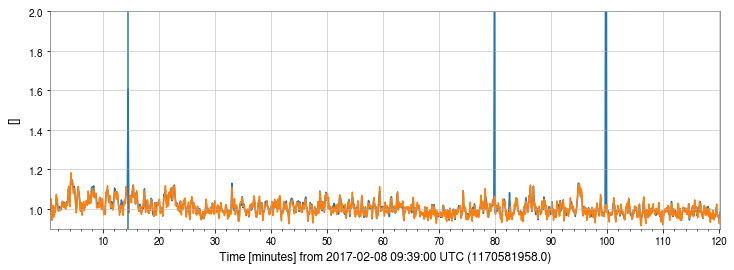

In [216]:
p1 = (my_rms).plot()
p1.gca().plot(rmd)
p1.gca().set_ylim(0.9,2)
p1.gca().axvline(1170582798+20)

In [217]:
tconvert('2017-02-08 9:53:20')

LIGOTimeGPS(1170582818, 0)

53

## Calculating the errors

This next section calculates the error on the PSD variation estimate, by modeling as a sum of weighted chi-squared variables. This can safely be ignored.

In [209]:
asd = data.asd(8,4,method='median')
weight = asd.frequencies**(-7./6.)/asd
weight[:8*20]=0.
weight[8*480:]=0.

In [210]:
sum(weight**2)/(sum(weight)**2)

<Index 0.00040756>

In [223]:
sqrt(2*0.00040755575/(2))

0.020188010055475998

In [212]:
sqrt(0.0001018889375)

0.010094005027737999

In [219]:
asd2 = data.asd(1,0.5,method='median')
weight2 = asd2.frequencies**(-7./6.)/asd2
weight2[:1*20]=0.
weight2[1*480:]=0.

In [215]:
sum(weight2**2)/(sum(weight2)**2)

<Index 0.00165027>

In [21]:
min(data.time

1170581984.0

In [17]:
p1 = qtransform.plot()
p1.gca().plot()

0.016666666666666666

In [217]:
1./(sum(weight**2)/(sum(weight)**2))

<Index 2453.65202567>

In [220]:
1./(sum(weight2**2)/(sum(weight2)**2))

<Index 312.51094272>